### Sirada Thoungvitayasutee 301292632
### Assignment 3

#### Github: https://github.com/venussirada/COMP257/blob/main/Assignment3/SiradaThoungvitayasutee_COMP257_Assignment3.ipynb

In [1]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
from scipy.stats import mode

#### 1. Retrieve and load the Olivetti faces dataset.

In [2]:
data = fetch_olivetti_faces(shuffle=True, random_state=42)
X = data.data
y = data.target

In [3]:
print(X.shape)
print(y.shape)

(400, 4096)
(400,)


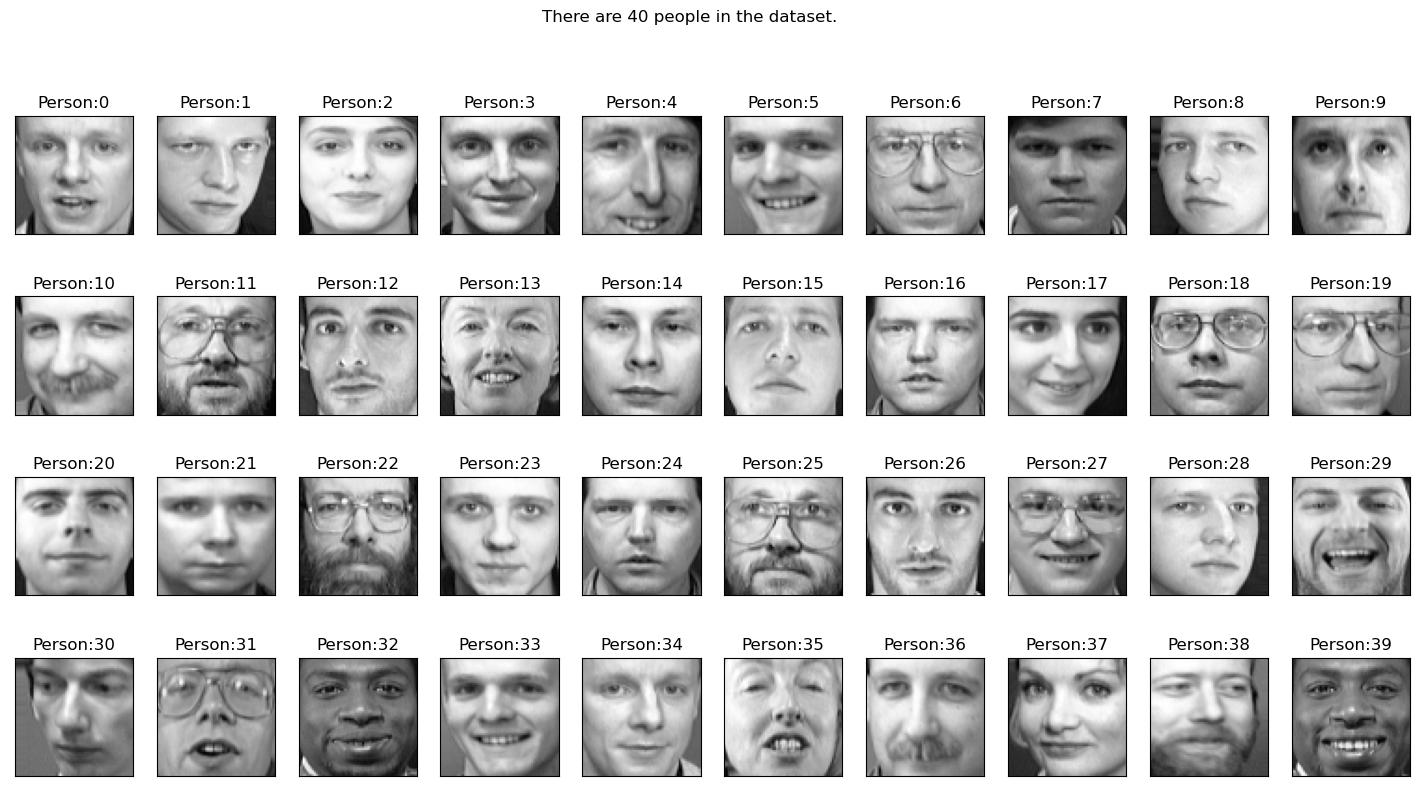

In [4]:
#print sample of the faces
def show_sample_faces(images, unique_ids):
    fig, axarr = plt.subplots(nrows=4, ncols=10, figsize=(18,9))
    axarr = axarr.flatten()
    
    for unique_id in unique_ids:
        image_index = unique_id*10
        #reshape from flattened to 64x64
        image_reshaped = images[image_index].reshape(64,64) 
        axarr[unique_id].imshow(image_reshaped, cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title('Person:{}'.format(unique_id))
    plt.suptitle('There are 40 people in the dataset.')

show_sample_faces(X, np.unique(y))

#### 2. Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same number of images per person in each set. 

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, temp_index = next(split.split(X,y))
X_train, X_temp = X[train_index], X[temp_index]
y_train, y_temp = y[train_index], y[temp_index]

#split testing and val
split_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_index, test_index = next(split_val_test.split(X_temp, y_temp))
X_val, X_test = X_temp[val_index], X_temp[test_index]
y_val, y_test = y_temp[val_index], y_temp[test_index]
#output
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Val set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (320, 4096), (320,)
Val set: (40, 4096), (40,)
Test set: (40, 4096), (40,)


<AxesSubplot:title={'center':'Training Set: Number of Samples Per Class'}, xlabel='subject ids'>

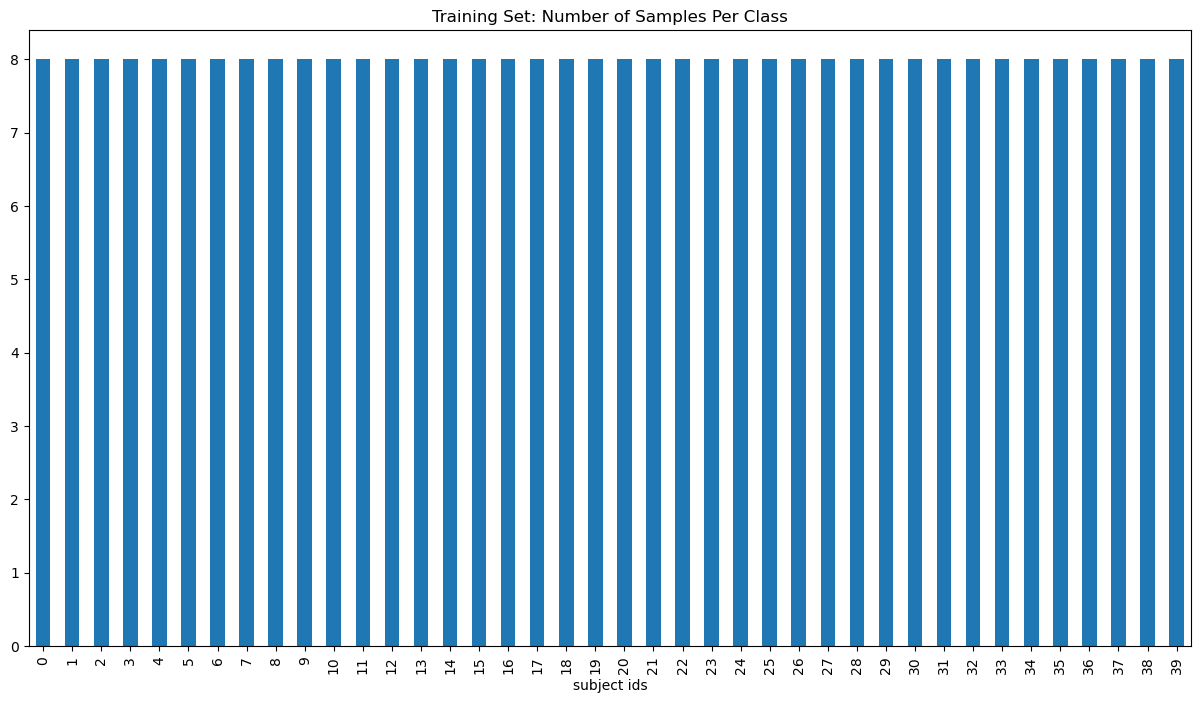

In [6]:
#print the graph to ensure that each person has same number of images
y_frame = pd.DataFrame()
y_frame['subject ids'] = y_train
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8), title='Training Set: Number of Samples Per Class')

<AxesSubplot:title={'center':'Validation Set: Number of Samples Per Class'}, xlabel='subject ids'>

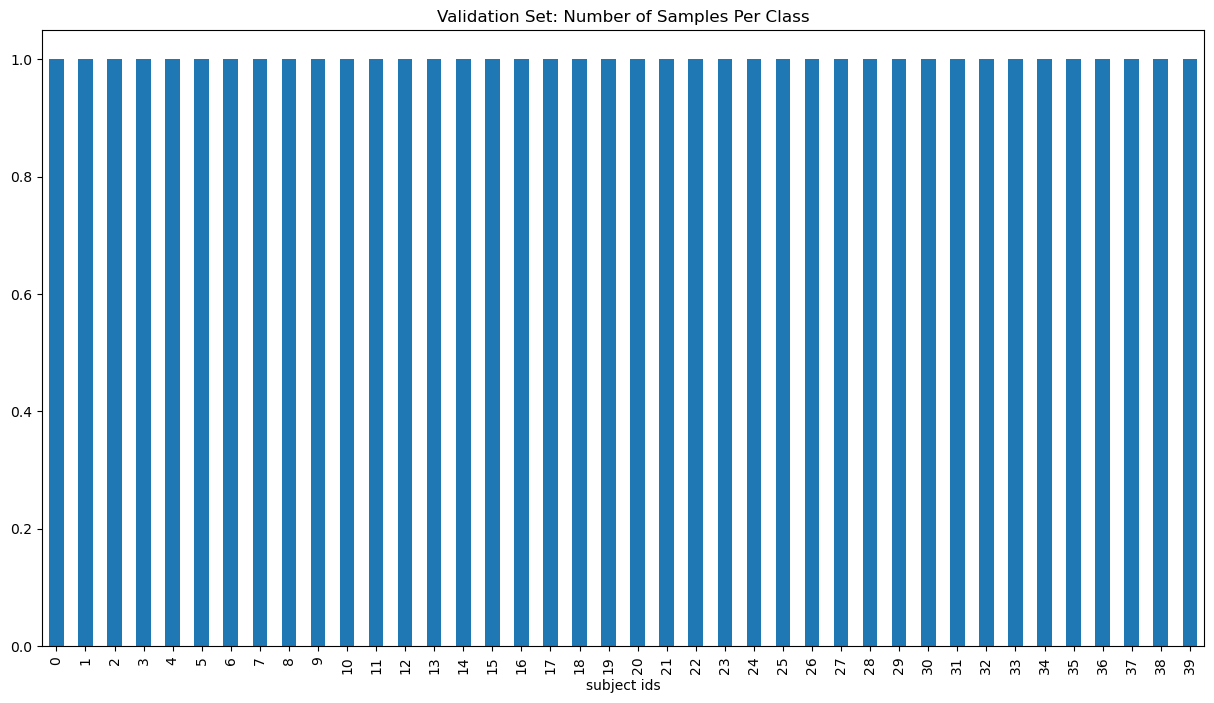

In [7]:
#print the graph to ensure that each person has same number of images
y_frame = pd.DataFrame()
y_frame['subject ids'] = y_val
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8), title='Validation Set: Number of Samples Per Class')

<AxesSubplot:title={'center':'Testing Set: Number of Samples Per Class'}, xlabel='subject ids'>

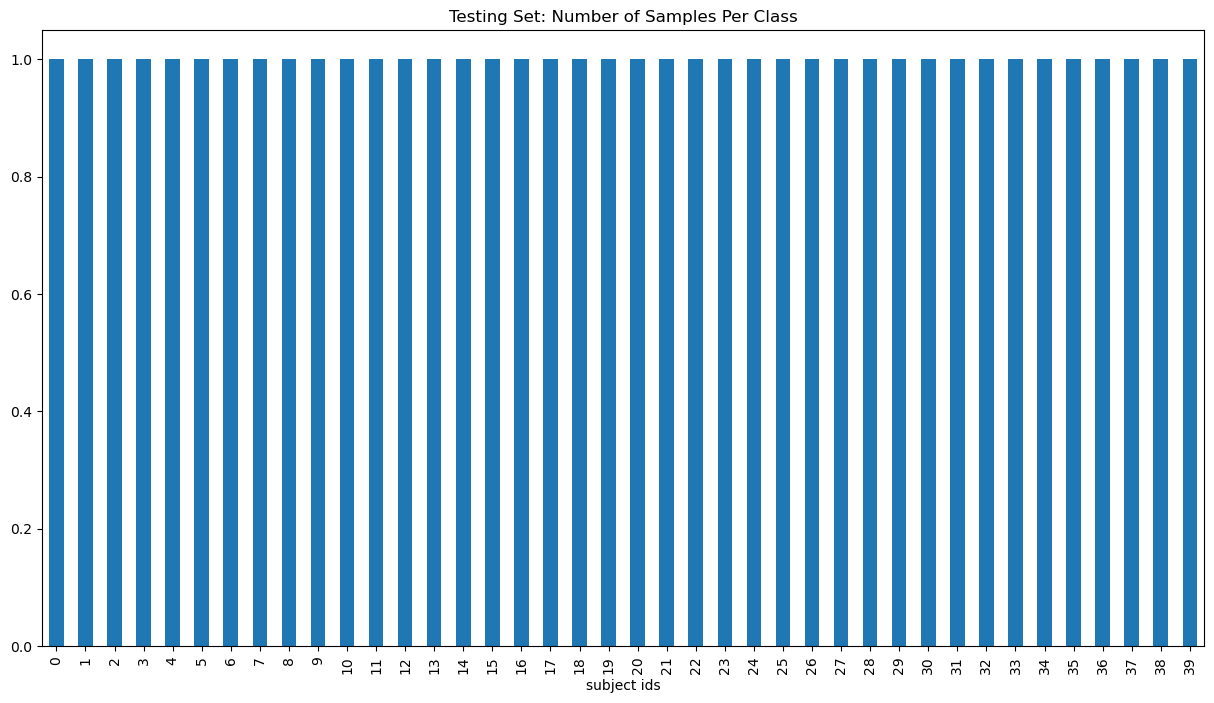

In [8]:
#print the graph to ensure that each person has same number of images
y_frame = pd.DataFrame()
y_frame['subject ids'] = y_test
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8), title='Testing Set: Number of Samples Per Class')

#### 3. Using k-fold cross validation, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.

In [9]:
#define a classifier
clf = LogisticRegression(max_iter=1000, random_state=42)

#perform a k-fold cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#train classifier on validation set
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=kf)

print(f'Cross-validation scores (5 folds): {cross_val_scores}')
print(f'Mean cross-validation scores: {cross_val_scores.mean()}')

#train the model
clf.fit(X_train, y_train)

#evaluate the model
y_val_pred = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')

Cross-validation scores (5 folds): [0.984375 0.90625  0.984375 0.953125 0.9375  ]
Mean cross-validation scores: 0.953125
Validation Accuracy: 0.95


#### 4. Using either Agglomerative Hierarchical Clustering (AHC) or Divisive Hierarchical Clustering (DHC) and using the centroid-based clustering rule, reduce the dimensionality of the set by using the following similarity measures

In [10]:
#number of cluster = 40 because there are 40 people in the images
n_clusters = 40

In [11]:
def get_centroids(X, labels):
    unique_labels = np.unique(labels)
    #an array to store centroid
    centroids = np.zeros((len(unique_labels), X.shape[1]))
    for i, label in enumerate(unique_labels):
        #get all points in the cluster
        points_in_cluster = X[labels == label]
        #calculate the centroid of the points in the cluster
        centroids[i, :] = points_in_cluster.mean(axis=0)
    return centroids

#### a) Euclidean Distance

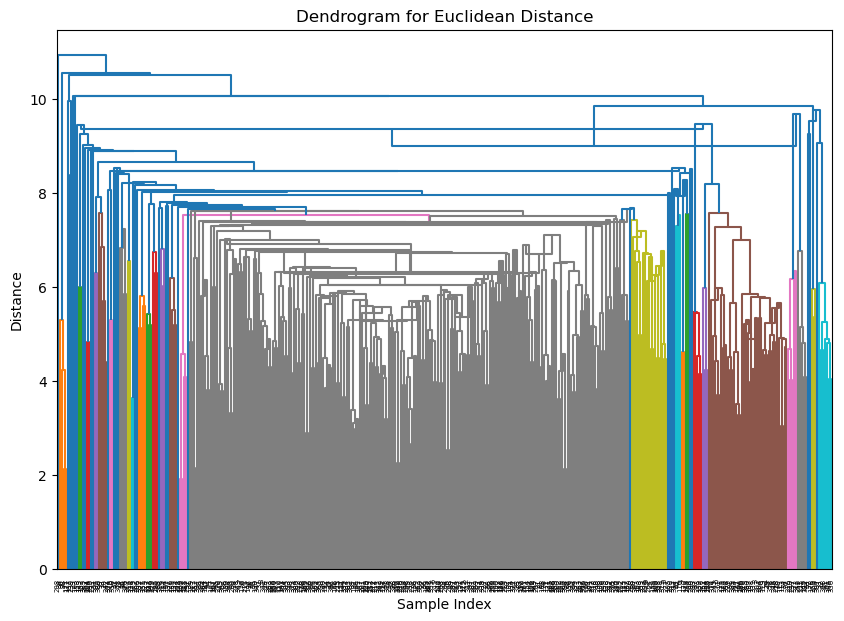

In [12]:
#compute the distance using euclidean

#AgglomerativeClustering does not support centroid-based linkage
#use linkage from scipy
dist_euclidean = pdist(X, metric='euclidean')
#compute the euclidean distance
#perform agglomerative clustering
Z_euclidean = linkage(dist_euclidean, method='centroid')

#create cluster based on the hierachy. maxclust so cluster no more than 40
labels_euclidean = fcluster(Z_euclidean, t=n_clusters, criterion='maxclust')

#plot the dendrogram
plt.figure(figsize=(10,7))
dendrogram(Z_euclidean)
plt.title('Dendrogram for Euclidean Distance')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [13]:
#calculate centroid
X_reduced_euclidean = get_centroids(X, labels_euclidean)

print(f'Original dataset shape: {X.shape}')
print(f'Reduced dataset shape: {X_reduced_euclidean.shape}')

#from 400 samples, grouped to 40 clusters

Original dataset shape: (400, 4096)
Reduced dataset shape: (40, 4096)


#### b) Minkowski Distance

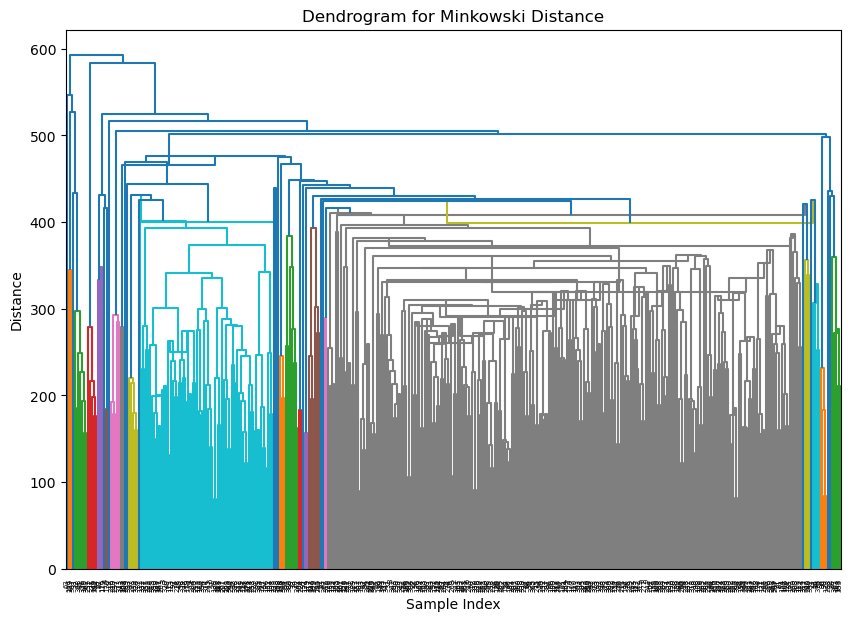

In [14]:
#compute the distance using minkowski
#add p=1 so that it is manhattan not euclidean
dist_minkowski = pdist(X, metric='minkowski', p=1)
Z_minkowski = linkage(dist_minkowski, method='centroid')
labels_minkowski = fcluster(Z_minkowski, t=n_clusters, criterion='maxclust')

#plot the dendrogram
plt.figure(figsize=(10,7))
dendrogram(Z_minkowski)
plt.title('Dendrogram for Minkowski Distance')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [15]:
#calculate using centroid
X_reduced_minkowski = get_centroids(X, labels_minkowski)
print(f'Original dataset shape: {X.shape}')
print(f'Reduced dataset shape: {X_reduced_minkowski.shape}')

Original dataset shape: (400, 4096)
Reduced dataset shape: (40, 4096)


#### c) Cosine Similarity

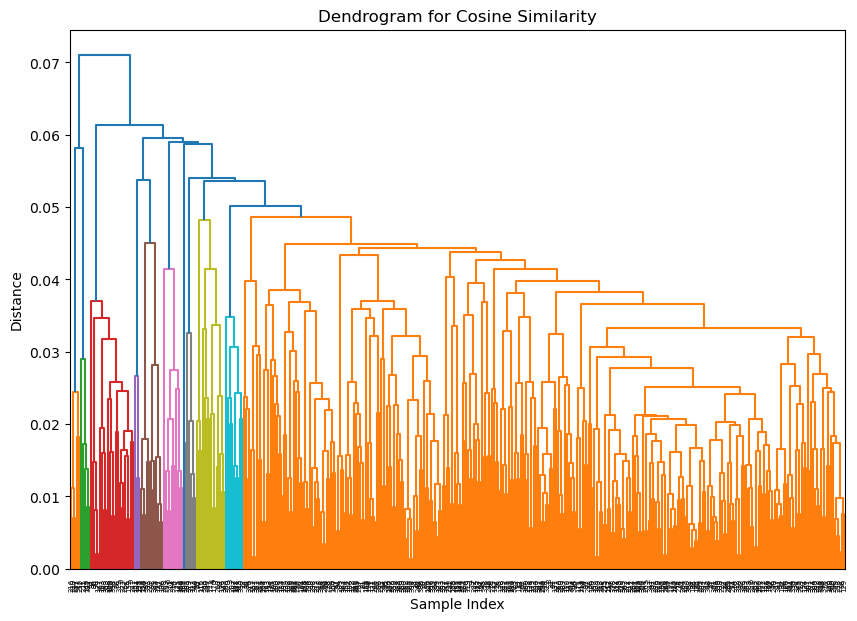

In [16]:
dist_cosine = pdist(X, metric='cosine')
#cosine is not distance, so centroid cannot be used
Z_cosine = linkage(dist_cosine, method='average')

#plot the dendrogram
plt.figure(figsize=(10,7))
dendrogram(Z_cosine)
plt.title('Dendrogram for Cosine Similarity')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [17]:
labels_cosine = fcluster(Z_cosine, t=n_clusters, criterion='maxclust')
X_reduced_cosine = get_centroids(X, labels_cosine)
print(f'Original dataset shape: {X.shape}')
print(f'Reduced dataset shape: {X_reduced_cosine.shape}')

Original dataset shape: (400, 4096)
Reduced dataset shape: (40, 4096)


#### 5. Discuss any discrepancies observed between 4(a), 4(b), or 4(c).
#### Use the silhouette score approach to choose the number of clusters for 4(a), 4(b), and 4(c)

In [18]:
#find optimal number of clusters for each approach
cluster_range = range(20,150)

#store silhouette scores
silhouette_scores_all = {'euclidean':[], 'minkowski':[], 'cosine':[]}

#calculate score for each number of cluster
for n_cluster in cluster_range:
    #euclidean
    labels_euclidean = fcluster(Z_euclidean, t=n_cluster, criterion='maxclust')
    silhouette_score_euclidean = silhouette_score(X, labels_euclidean, metric='euclidean')
    silhouette_scores_all['euclidean'].append(silhouette_score_euclidean)
    
    #minkowski
    labels_minkowski = fcluster(Z_minkowski, t=n_cluster, criterion='maxclust')
    silhouette_score_minkowski = silhouette_score(X, labels_minkowski, metric='minkowski')
    silhouette_scores_all['minkowski'].append(silhouette_score_minkowski)
    
    #cosine
    labels_cosine = fcluster(Z_cosine, t=n_cluster, criterion='maxclust')
    silhouette_score_cosine = silhouette_score(X, labels_cosine, metric='cosine')
    silhouette_scores_all['cosine'].append(silhouette_score_cosine)

In [19]:
#find optimal number of clusters
optimal_euclidean = cluster_range[np.argmax(silhouette_scores_all['euclidean'])]
optimal_minkowski = cluster_range[np.argmax(silhouette_scores_all['minkowski'])]
optimal_cosine = cluster_range[np.argmax(silhouette_scores_all['cosine'])]

print(f"Optimal Number of Clusters for Euclidean: {optimal_euclidean}, Silhouette Score: {max(silhouette_scores_all['euclidean'])}")
print(f"Optimal Number of Clusters for Minkowski: {optimal_minkowski},Silhouette Score: {max(silhouette_scores_all['minkowski'])}")
print(f"Optimal Number of Clusters for Cosine: {optimal_cosine}, Silhouette Score: {max(silhouette_scores_all['cosine'])}")

Optimal Number of Clusters for Euclidean: 142, Silhouette Score: 0.1113823801279068
Optimal Number of Clusters for Minkowski: 146,Silhouette Score: 0.18381849576678871
Optimal Number of Clusters for Cosine: 143, Silhouette Score: 0.30080103874206543


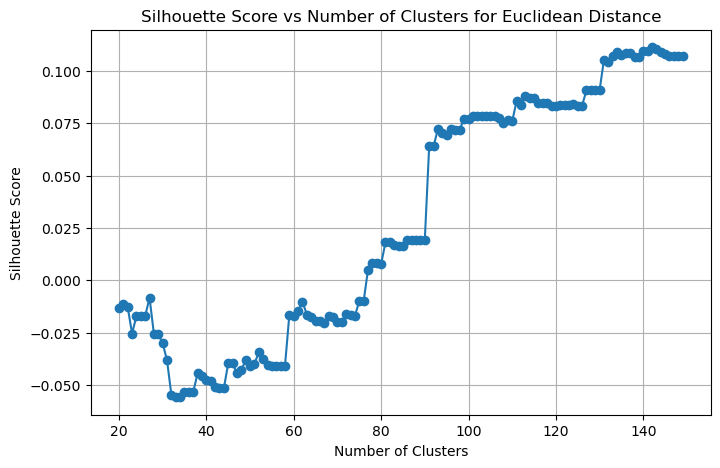

In [20]:
#plot the silhouette scores for euclidean
plt.figure(figsize=(8,5))
plt.plot(cluster_range, silhouette_scores_all['euclidean'], label='Euclidean', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters for Euclidean Distance')
plt.grid(True)
plt.show()

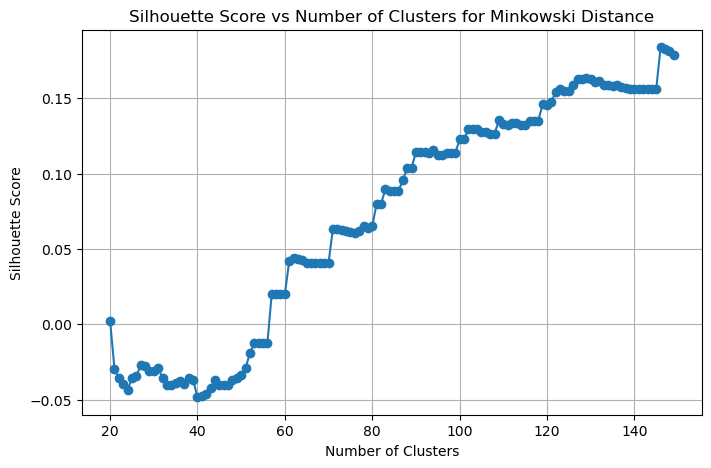

In [21]:
#plot the silhouette scores for minkowski
plt.figure(figsize=(8,5))
plt.plot(cluster_range, silhouette_scores_all['minkowski'], label='Minkowski', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters for Minkowski Distance')
plt.grid(True)
plt.show()

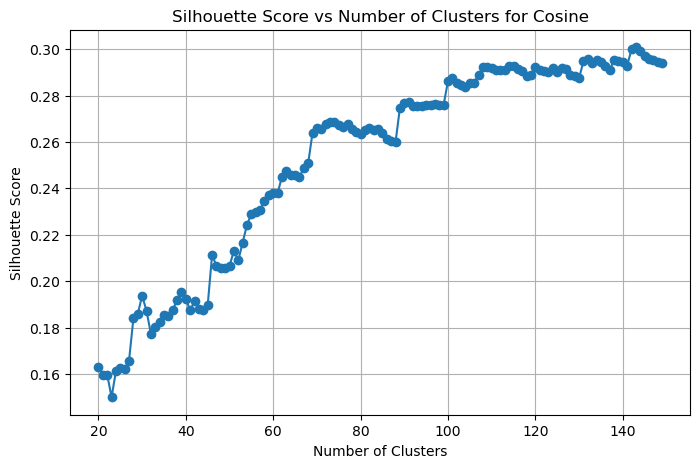

In [22]:
#plot the silhouette scores for cosine
plt.figure(figsize=(8,5))
plt.plot(cluster_range, silhouette_scores_all['cosine'], label='Cosine', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters for Cosine')
plt.grid(True)
plt.show()

#### 6. Use the set from (4(a), 4(b), or 4(c)) to train a classifier as in (3) using k-fold cross validation.

In [23]:
#use the optimal cluster to reduce the dataset
#euclidean distance

dist_euclidean = pdist(X, metric='euclidean')
Z_euclidean = linkage(dist_euclidean, method='centroid')
labels_euclidean = fcluster(Z_euclidean, t=optimal_euclidean, criterion='maxclust')

In [24]:
#minkowski
dist_minkowski = pdist(X, metric='minkowski',p=1)
Z_minkowski = linkage(dist_minkowski, method='centroid')
labels_minkowski = fcluster(Z_minkowski, t=optimal_minkowski, criterion='maxclust')

In [25]:
#cosine
dist_cosine = pdist(X, metric='cosine')
Z_cosine = linkage(dist_cosine, method='average')
labels_cosine = fcluster(Z_cosine, t=optimal_cosine, criterion='maxclust')

In [26]:
#get x reduced
X_reduced_euclidean = get_centroids(X, labels_euclidean)
X_reduced_minkowski = get_centroids(X, labels_minkowski)
X_reduced_cosine = get_centroids(X, labels_cosine)

In [27]:
#get y reduced
def get_y_reduced(y, cluster_labels):
    #get cluster id
    unique_clusters = np.unique(cluster_labels)
    y_reduced=[]
    
    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster)
        cluster_labels_in_cluster = y[cluster_indices]
        #assign mode in the cluster
        mode_cluster = mode(cluster_labels_in_cluster).mode[0]
        y_reduced.append(mode_cluster)
    return np.array(y_reduced)

In [28]:
#y reduced
y_reduced_euclidean = get_y_reduced(y, labels_euclidean)
y_reduced_minkowski = get_y_reduced(y, labels_minkowski)
y_reduced_cosine = get_y_reduced(y, labels_cosine)

print(f'X Reduced Euclidean: {X_reduced_euclidean.shape}')
print(f'Y Reduced Euclidean: {y_reduced_euclidean.shape}')
print('')
print(f'X Reduced Minkowski: {X_reduced_minkowski.shape}')
print(f'Y Reduced Minkowski: {y_reduced_minkowski.shape}')
print('')
print(f'X Reduced Cosine: {X_reduced_cosine.shape}')
print(f'Y Reduced Cosine: {y_reduced_cosine.shape}')

X Reduced Euclidean: (142, 4096)
Y Reduced Euclidean: (142,)

X Reduced Minkowski: (146, 4096)
Y Reduced Minkowski: (146,)

X Reduced Cosine: (143, 4096)
Y Reduced Cosine: (143,)


In [29]:
#train test split
#euclidean

X_train_euclidean, X_temp_euclidean, y_train_euclidean, y_temp_euclidean = train_test_split(X_reduced_euclidean, y_reduced_euclidean, test_size=0.2, random_state=42)
X_val_euclidean, X_test_euclidean, y_val_euclidean, y_test_euclidean = train_test_split(X_temp_euclidean, y_temp_euclidean, test_size=0.5, random_state=42)

In [30]:
#minkowski

X_train_minkowski, X_temp_minkowski, y_train_minkowski, y_temp_minkowski = train_test_split(X_reduced_minkowski, y_reduced_minkowski, test_size=0.2, random_state=42)
X_val_minkowski, X_test_minkowski, y_val_minkowski, y_test_minkowski = train_test_split(X_temp_minkowski, y_temp_minkowski, test_size=0.5, random_state=42)

In [31]:
#cosine
X_train_cosine, X_temp_cosine, y_train_cosine, y_temp_cosine = train_test_split(X_reduced_cosine, y_reduced_cosine, test_size=0.2, random_state=42)
X_val_cosine, X_test_cosine, y_val_cosine, y_test_cosine = train_test_split(X_temp_cosine, y_temp_cosine, test_size=0.5, random_state=42)

In [32]:
#check the size
print('Euclidean')
print(f'X Train: {X_train_euclidean.shape}')
print(f'Y Train: {y_train_euclidean.shape}')
print(f'X Validation: {X_val_euclidean.shape}')
print(f'Y Validation: {y_val_euclidean.shape}')
print(f'X Test: {X_test_euclidean.shape}')
print(f'Y Test: {y_test_euclidean.shape}')
print('')
print('Minkowski')
print(f'X Train: {X_train_minkowski.shape}')
print(f'Y Train: {y_train_minkowski.shape}')
print(f'X Validation: {X_val_minkowski.shape}')
print(f'Y Validation: {y_val_minkowski.shape}')
print(f'X Test: {X_test_minkowski.shape}')
print(f'Y Test: {y_test_minkowski.shape}')
print('')
print('Cosine')
print(f'X Train: {X_train_cosine.shape}')
print(f'Y Train: {y_train_cosine.shape}')
print(f'X Validation: {X_val_cosine.shape}')
print(f'Y Validation: {y_val_cosine.shape}')
print(f'X Test: {X_test_cosine.shape}')
print(f'Y Test: {y_test_cosine.shape}')

Euclidean
X Train: (113, 4096)
Y Train: (113,)
X Validation: (14, 4096)
Y Validation: (14,)
X Test: (15, 4096)
Y Test: (15,)

Minkowski
X Train: (116, 4096)
Y Train: (116,)
X Validation: (15, 4096)
Y Validation: (15,)
X Test: (15, 4096)
Y Test: (15,)

Cosine
X Train: (114, 4096)
Y Train: (114,)
X Validation: (14, 4096)
Y Validation: (14,)
X Test: (15, 4096)
Y Test: (15,)


In [33]:
#train the classifier
#define a classifier
clf = LogisticRegression(max_iter=1000, random_state=42)

#perform a k-fold cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#euclidean
cross_val_scores_euclidean = cross_val_score(clf, X_train_euclidean, y_train_euclidean, cv=kf)
print('Euclidean')
print(f'Cross-validation scores (5 folds): {cross_val_scores_euclidean}')
print(f'Mean cross-validation scores: {cross_val_scores_euclidean.mean():.4f}')
print('')
#minkowski
cross_val_scores_minkowski = cross_val_score(clf, X_train_minkowski, y_train_minkowski, cv=kf)
print('Minkowski')
print(f'Cross-validation scores (5 folds): {cross_val_scores_minkowski}')
print(f'Mean cross-validation scores: {cross_val_scores_minkowski.mean():.4f}')
print('')
#cosine
cross_val_scores_cosine = cross_val_score(clf, X_train_cosine, y_train_cosine, cv=kf)
print('Cosine')
print(f'Cross-validation scores (5 folds): {cross_val_scores_cosine}')
print(f'Mean cross-validation scores: {cross_val_scores_cosine.mean():.4f}')

Euclidean
Cross-validation scores (5 folds): [0.73913043 0.73913043 0.65217391 0.81818182 0.81818182]
Mean cross-validation scores: 0.7534

Minkowski
Cross-validation scores (5 folds): [0.70833333 0.60869565 0.7826087  0.56521739 0.7826087 ]
Mean cross-validation scores: 0.6895

Cosine
Cross-validation scores (5 folds): [0.65217391 0.56521739 0.73913043 0.91304348 0.77272727]
Mean cross-validation scores: 0.7285


In [34]:
#train the model
#euclidean
clf.fit(X_train_euclidean, y_train_euclidean)
#evaluate the model
y_val_pred_euclidean = clf.predict(X_val_euclidean)
val_accuracy_euclidean = accuracy_score(y_val_euclidean, y_val_pred_euclidean)

print(f'Validation Accuracy for Euclidean: {val_accuracy_euclidean:.4f}')
print('')

#minkowski
clf.fit(X_train_minkowski, y_train_minkowski)
#evaluate the model
y_val_pred_minkowski = clf.predict(X_val_minkowski)
val_accuracy_minkowski = accuracy_score(y_val_minkowski, y_val_pred_minkowski)
print(f'Validation Accuracy for Minkowski: {val_accuracy_minkowski:.4f}')
print('')

#cosine
clf.fit(X_train_cosine, y_train_cosine)
#evaluate the model
y_val_pred_cosine = clf.predict(X_val_cosine)
val_accuracy_cosine = accuracy_score(y_val_cosine, y_val_pred_cosine)
print(f'Validation Accuracy for Cosine: {val_accuracy_cosine:.4f}')

Validation Accuracy for Euclidean: 0.7143

Validation Accuracy for Minkowski: 0.9333

Validation Accuracy for Cosine: 0.8571


References:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
https://scikit-learn.org/dev/modules/generated/sklearn.cluster.AgglomerativeClustering.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html 
